In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import pickle

In [3]:
df = pd.read_csv("Housing_Price_Data.csv",delimiter=";")
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000.0,7420,4.0,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000.0,8960,4.0,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000.0,9960,3.0,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000.0,7500,4.0,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000.0,7420,4.0,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000.0,3000,2.0,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150.0,2400,3.0,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000.0,3620,2.0,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000.0,2910,3.0,1,1,no,no,no,no,no,0,no,furnished


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             542 non-null    float64
 1   area              545 non-null    int64  
 2   bedrooms          541 non-null    float64
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          543 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   545 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           545 non-null    int64  
 11  prefarea          545 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 55.5+ KB


There are some empty values in the columns "price," "bedrooms," and "mainroad." Additionally, there's a format mismatch in the "bedrooms" variable. I'll change the format from float to integer.

In [14]:
df.duplicated().sum()

np.int64(0)

no duplicated value

# Data Preparation
To avoid data leakage, every processing step should be applied only after splitting the dataset.
### Splitting Set

In [4]:
input_df = df.drop(columns="price")
output_df = df["price"]

x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=42)
print("the size of xtrain", x_train.shape, "\nthe size of xtest", x_test.shape)

the size of xtrain (436, 12) 
the size of xtest (109, 12)


 Since the "price" column is continuous and numerical, I will replace the missing values with the mean of the column. For the "bedrooms" and "mainroad" columns, which are discrete and categorical, I will replace the missing values with the mode of each respective column.

In [5]:
y_train = y_train.fillna(y_train.mean())
x_train['bedrooms'] = x_train['bedrooms'].fillna(x_train['bedrooms'].mode()[0])
x_train['mainroad'] = x_train['mainroad'].fillna(x_train['mainroad'].mode()[0])

y_test = y_test.fillna(y_test.mean())
x_test['bedrooms'] = x_test['bedrooms'].fillna(x_test['bedrooms'].mode()[0])
x_test['mainroad'] = x_test['mainroad'].fillna(x_test['mainroad'].mode()[0])

In [46]:
print(x_train.isna().sum())
print(y_train.isna().sum())
print(x_test.isna().sum())
print(x_test.isna().sum())

area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [6]:
x_train["bedrooms"] = x_train["bedrooms"].astype(int)
x_test["bedrooms"] = x_test["bedrooms"].astype(int)

print(x_train["bedrooms"].dtype )
print(x_test["bedrooms"].dtype )

int64
int64


now all empty values have been filled

In [7]:
object = [col for col in x_train.columns if x_train[col].dtype == "object"]
numeric = [col for col in x_train.select_dtypes("number").columns]
print(object, "\n", numeric)

['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'] 
 ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


In [8]:
disc_obj = ["bedrooms", "bathrooms", "stories","parking"] + [col for col in x_train.columns if x_train[col].dtype == "object"]
continous = ["price","area"]
disc_obj

['bedrooms',
 'bathrooms',
 'stories',
 'parking',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

### Checking & Handling Outliers

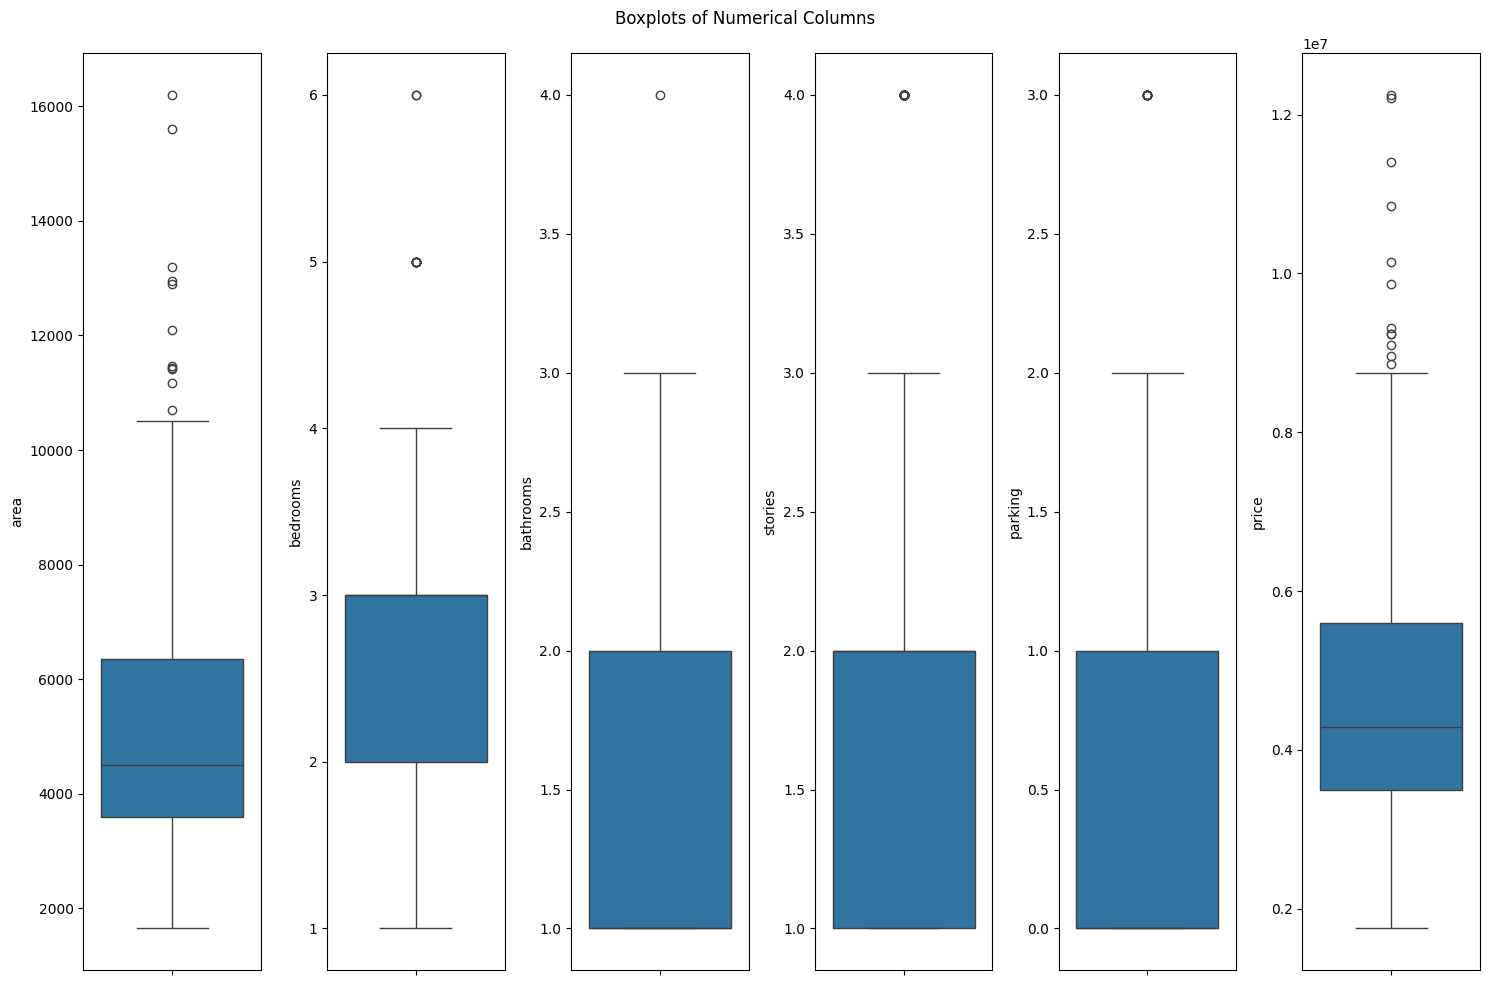

In [39]:
fig, axes = plt.subplots(1,len(numeric) + 1,figsize=(15,10))
axes = axes.flatten()
for ax, col in zip(axes[:-1], numeric):
    sns.boxplot(data =x_train, y=col, ax=ax)

y_train_df = pd.DataFrame(y_train, columns=['price'])
sns.boxplot(data =y_train_df, y="price", ax=axes[-1])

fig.suptitle("Boxplots of Numerical Columns")
plt.tight_layout()

Judging from the plots, it is apparent that the main causes of outliers are the vastly different proportions of the bathrooms, stories, and parking columns. In this dataset, large houses with exceptional facilities are much rarer than normal houses, which affects the distributions of the data. It is not necessary to check the number of outliers using the IQR method because this has already been validated by the cardinality check mentioned above. Here’s the result:

In [9]:
unique = [x_train[col].value_counts() for col in disc_obj]
unique

[bedrooms
 3    238
 2    111
 4     75
 5      8
 6      2
 1      2
 Name: count, dtype: int64,
 bathrooms
 1    326
 2    105
 3      4
 4      1
 Name: count, dtype: int64,
 stories
 2    188
 1    187
 4     31
 3     30
 Name: count, dtype: int64,
 parking
 0    240
 1    102
 2     85
 3      9
 Name: count, dtype: int64,
 mainroad
 yes    374
 no      62
 Name: count, dtype: int64,
 guestroom
 no     358
 yes     78
 Name: count, dtype: int64,
 basement
 no     280
 yes    156
 Name: count, dtype: int64,
 hotwaterheating
 no     414
 yes     22
 Name: count, dtype: int64,
 airconditioning
 no     302
 yes    134
 Name: count, dtype: int64,
 prefarea
 no     334
 yes    102
 Name: count, dtype: int64,
 furnishingstatus
 semi-furnished    188
 unfurnished       137
 furnished         111
 Name: count, dtype: int64]

In [29]:
x_test

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house
0,5900,4,2,2,no,no,yes,no,no,1,no,unfurnished,1475.000000,0.500000,0,0
1,6500,3,2,3,yes,no,no,no,yes,0,yes,furnished,2166.666667,0.666667,1,0
2,4040,2,1,1,yes,no,no,no,no,0,no,semi-furnished,2020.000000,0.500000,0,0
3,5000,3,1,2,yes,no,no,no,yes,0,no,semi-furnished,1666.666667,0.333333,0,0
4,3960,3,1,1,yes,no,no,no,no,0,no,furnished,1320.000000,0.333333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,6000,4,1,2,yes,no,yes,no,no,2,no,semi-furnished,1500.000000,0.250000,0,0
105,6930,4,1,2,no,no,no,no,no,1,no,furnished,1732.500000,0.250000,0,0
106,6000,4,2,4,yes,no,no,no,yes,1,no,semi-furnished,1500.000000,0.500000,0,0
107,6000,3,2,2,yes,yes,no,no,yes,1,no,semi-furnished,2000.000000,0.666667,0,0


In [31]:
unique2 = [x_test[col].value_counts() for col in disc_obj]
unique2 

[bedrooms
 3    62
 2    25
 4    20
 5     2
 Name: count, dtype: int64,
 bathrooms
 1    75
 2    28
 3     6
 Name: count, dtype: int64,
 stories
 2    50
 1    40
 4    10
 3     9
 Name: count, dtype: int64,
 parking
 0    59
 1    24
 2    23
 3     3
 Name: count, dtype: int64,
 mainroad
 yes    94
 no     15
 Name: count, dtype: int64,
 guestroom
 no     90
 yes    19
 Name: count, dtype: int64,
 basement
 no     74
 yes    35
 Name: count, dtype: int64,
 hotwaterheating
 no     106
 yes      3
 Name: count, dtype: int64,
 airconditioning
 no     71
 yes    38
 Name: count, dtype: int64,
 prefarea
 no     83
 yes    26
 Name: count, dtype: int64,
 furnishingstatus
 unfurnished       41
 semi-furnished    39
 furnished         29
 Name: count, dtype: int64]

For instance: The distribution shows a clear concentration of houses with 2 to 4 bedrooms, while houses with 1,5,6 are significantly less common Similarly, the imbalance proportions of houses having 3 or more bathrooms and houses having 3 parkings. 

Given the data distributions, I’ve decided not to remove or impute the outliers to preserve valuable high-end properties despite their rarity. Instead, I will use RobustScaler, which scales features based on the median and interquartile range (IQR). This approach effectively handles outliers, reducing their impact while retaining all data for a comprehensive analysis.


### Feature Encoding

Because all these object values are nominal variables without an inherent order, the suitable encoder is the OneHotEncoder.

In [10]:
x_train = x_train.reset_index(drop=True)
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_features = one_hot_encoder.fit_transform(x_train[object])
x_train_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_train_encoded = pd.concat([x_train, x_train_encoded], axis=1).drop(object, axis=1)

x_test = x_test.reset_index(drop=True)
encoded_features = one_hot_encoder.transform(x_test[object])
x_test_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_test_encoded = pd.concat([x_test, x_test_encoded], axis=1).drop(object, axis=1)


In [11]:
x_train_encoded.head(3)

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,6000,3,2,4,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7200,3,2,1,3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3816,2,1,1,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [112]:
x_test_encoded.head(3)

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,5900,4,2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,6500,3,2,3,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4040,2,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Scalling

In [12]:
scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_encoded.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test_encoded.columns)

In [117]:
x_train_scaled.head(3)

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.543478,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.978261,0.0,1.0,-1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.247826,-1.0,0.0,-1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [118]:
x_test_scaled.head(3)

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.507246,1.0,1.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.724638,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.166667,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Prediction Models

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [15]:
results = {}

def build_models(parameters, algorithm, name):
    model = algorithm()
    if parameters:
        model.set_params(**parameters)

    model.fit(x_train_scaled, y_train)
    y_predict=model.predict(x_test_scaled)

    mse = mean_squared_error(y_test, y_predict).round(2)
    rmse = np.sqrt(mse).round(2)
    mape = (mean_absolute_percentage_error(y_test, y_predict) * 100).round(2)

    results[name] = {
        'MSE': float(mse),
        'RMSE': float(rmse),
        'MAPE': float(mape)
    }    

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE: ", mape, "%")

In [16]:
def tuning(parameters, algorithm, name):
    tuning= GridSearchCV(algorithm(),
                            param_grid = parameters,   
                            scoring='neg_mean_squared_error',        
                            cv=5, n_jobs= -1, verbose=0)  
    tuning.fit(x_train_scaled,y_train)
    best_params = tuning.best_params_
    best_score = -tuning.best_score_

    print("Tuned Hyperparameters :", best_params)
    print("Best Score :",best_score)

    build_models(best_params, algorithm, name)

Model Performance Metrics
- MSE (Mean Squared Error): Measures the average squared difference between predicted and actual values. Lower values indicate better model performance.
- RMSE (Root Mean Squared Error): Square root of the MSE provides error magnitude in the same units as the target variable. Lower values indicate better performance.
- MAPE (Mean Absolute Percentage Error): Measures the average percentage difference between predicted and actual values. Lower values indicate better performance.

In [151]:
algorithm = LinearRegression
build_models(None, algorithm, "LinReg_model")

parameters = {
    'fit_intercept': [True, False],
}

tuning(parameters, algorithm, "Tuning_LinReg_model")

MSE: 1753889470095.9
RMSE: 1324344.92
MAPE:  21.03 %
Tuned Hyperparameters : {'fit_intercept': True}
Best Score : 1062627520806.3474
MSE: 1753889470095.9
RMSE: 1324344.92
MAPE:  21.03 %


In [153]:
algorithm = DecisionTreeRegressor
build_models(None, algorithm, "DT_model")

parameters = {
    'criterion': ['mse', 'friedman_mse', 'poisson'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

tuning(parameters, algorithm, "Tuning_DT_model")

MSE: 3042125823779.1
RMSE: 1744169.09
MAPE:  26.57 %
Tuned Hyperparameters : {'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Score : 1349350548866.245
MSE: 2407535044963.09
RMSE: 1551623.36
MAPE:  24.34 %


In [154]:
algorithm = RandomForestRegressor
build_models(None, algorithm, "RF_model")

parameters = {
    'n_estimators': [50, 100, 200],
    'criterion': ['mse', 'friedman_mse', 'poisson'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

tuning(parameters, algorithm, "Tuning_RF_model")

MSE: 1923374947859.27
RMSE: 1386857.94
MAPE:  21.72 %
Tuned Hyperparameters : {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score : 1084615513461.2717
MSE: 1952319508900.15
RMSE: 1397254.27
MAPE:  21.97 %


In [155]:
algorithm = KNeighborsRegressor
build_models(None, algorithm, "KNN_model")

parameters = {
    'n_neighbors': [3, 5, 7, 10, 15, 20], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2], 
    'leaf_size': [20, 30, 40, 50] 
}

tuning(parameters, algorithm, "Tuning_KNN_model")

MSE: 2400281756624.48
RMSE: 1549284.27
MAPE:  21.07 %
Tuned Hyperparameters : {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best Score : 1201514191212.0024
MSE: 2285881849927.17
RMSE: 1511913.31
MAPE:  20.81 %


In [156]:
algorithm = GradientBoostingRegressor
build_models(None, algorithm, "GBR_model")

parameters = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.001,0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [2, 4],
    'subsample': [0.9, 1.0],
}

tuning(parameters, algorithm, "Tuning_GBR_model")

MSE: 1666171338480.86
RMSE: 1290802.59
MAPE:  20.77 %
Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}
Best Score : 1137535998912.3682
MSE: 1837012469303.67
RMSE: 1355364.33
MAPE:  21.93 %


In [157]:
algorithm = AdaBoostRegressor
build_models(None, algorithm, "ADA_model")

parameters = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.001, 0.01, 0.1, 1.0], 
    'loss': ['linear', 'square', 'exponential'],
}

tuning(parameters, algorithm, "Tuning_ADA_model")

MSE: 2355967466521.59
RMSE: 1534916.11
MAPE:  27.37 %
Tuned Hyperparameters : {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 100}
Best Score : 1392770753767.3293
MSE: 2388332762963.26
RMSE: 1545423.17
MAPE:  27.04 %


In [158]:
algorithm = XGBRegressor
build_models(None, algorithm, "XGB_model")

parameters = {
    'n_estimators': [50,100, 200], 
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5], 
    'min_child_weight': [1,3, 5],  
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0, 0.1],
}

tuning(parameters, algorithm, "Tuning_XGB_model")

MSE: 2122720715850.06
RMSE: 1456955.98
MAPE:  22.38 %
Tuned Hyperparameters : {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Score : 1071856108197.9688
MSE: 1948041456409.45
RMSE: 1395722.56
MAPE:  22.23 %


In the first stacking, the model used the combination of the best-performing individual models to achieve the lowest error. In the second stacking approach, the model combined all original algorithms to leverage their collective performance.

In [159]:
estimators = [
    ('ln',  LinearRegression()),
    ('knn', KNeighborsRegressor(algorithm= 'auto', leaf_size= 30, n_neighbors= 10, p= 2, weights= 'distance')),
]

stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking.fit(x_train_scaled, y_train)
y_predict=stacking.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_predict).round(2)
rmse = np.sqrt(mse).round(2)
mape = (mean_absolute_percentage_error(y_test, y_predict) * 100).round(2)

results["stacking"] = {
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAPE': float(mape)
}

print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

MSE: 1772664747924.34
RMSE: 1331414.57
MAPE: 20.37 %


In [169]:
estimators = [
    ('ln',  LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),
    ('knn', KNeighborsRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('ada', AdaBoostRegressor()),
    ('xgb', XGBRegressor()),
]

stacking2 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking2.fit(x_train_scaled, y_train)
y_predict=stacking2.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_predict).round(2)
rmse = np.sqrt(mse).round(2)
mape = (mean_absolute_percentage_error(y_test, y_predict) * 100).round(2)

results["stacking2"] = {
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAPE': float(mape)
}

print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

MSE: 1844089528280.1
RMSE: 1357972.58
MAPE: 20.33 %


In [170]:
results

{'LinReg_model': {'MSE': 1753889470095.9, 'RMSE': 1324344.92, 'MAPE': 21.03},
 'Tuning_LinReg_model': {'MSE': 1753889470095.9,
  'RMSE': 1324344.92,
  'MAPE': 21.03},
 'DT_model': {'MSE': 3042125823779.1, 'RMSE': 1744169.09, 'MAPE': 26.57},
 'Tuning_DT_model': {'MSE': 2407535044963.09,
  'RMSE': 1551623.36,
  'MAPE': 24.34},
 'RF_model': {'MSE': 1923374947859.27, 'RMSE': 1386857.94, 'MAPE': 21.72},
 'Tuning_RF_model': {'MSE': 1952319508900.15,
  'RMSE': 1397254.27,
  'MAPE': 21.97},
 'KNN_model': {'MSE': 2400281756624.48, 'RMSE': 1549284.27, 'MAPE': 21.07},
 'Tuning_KNN_model': {'MSE': 2285881849927.17,
  'RMSE': 1511913.31,
  'MAPE': 20.81},
 'GBR_model': {'MSE': 1666171338480.86, 'RMSE': 1290802.59, 'MAPE': 20.77},
 'Tuning_GBR_model': {'MSE': 1837012469303.67,
  'RMSE': 1355364.33,
  'MAPE': 21.93},
 'ADA_model': {'MSE': 2355967466521.59, 'RMSE': 1534916.11, 'MAPE': 27.37},
 'Tuning_ADA_model': {'MSE': 2388332762963.26,
  'RMSE': 1545423.17,
  'MAPE': 27.04},
 'XGB_model': {'MSE': 2

### Insights:
- The stacking2 model has the lowest MAPE at 20.33%, indicating the best among the models. For an actual house price of $10,000,000, the RMSE of $1,357,972.58 suggests that the model's predictions are typically within approximately ±$1,357,972.58 of the true price. This implies that, on average, the model’s predictions are off by about ±20.33% of the actual price.
- Tuning impact: Some models show improvement with tuning (e.g., Decision Tree, KNN), while others have worsened performance (e.g., Random Forest, Gradient Boosting).

## attempt 2
create new features by capturing relationships between the existing features in training set to reduce the error score

In [14]:
unique

[bedrooms
 3    238
 2    111
 4     75
 5      8
 6      2
 1      2
 Name: count, dtype: int64,
 bathrooms
 1    326
 2    105
 3      4
 4      1
 Name: count, dtype: int64,
 stories
 2    188
 1    187
 4     31
 3     30
 Name: count, dtype: int64,
 parking
 0    240
 1    102
 2     85
 3      9
 Name: count, dtype: int64,
 mainroad
 yes    374
 no      62
 Name: count, dtype: int64,
 guestroom
 no     358
 yes     78
 Name: count, dtype: int64,
 basement
 no     280
 yes    156
 Name: count, dtype: int64,
 hotwaterheating
 no     414
 yes     22
 Name: count, dtype: int64,
 airconditioning
 no     302
 yes    134
 Name: count, dtype: int64,
 prefarea
 no     334
 yes    102
 Name: count, dtype: int64,
 furnishingstatus
 semi-furnished    188
 unfurnished       137
 furnished         111
 Name: count, dtype: int64]

In [19]:
x_train['area_per_bedroom'] = x_train['area'] / x_train['bedrooms']
x_train['bathroom_per_bedroom'] = x_train['bathrooms'] / x_train['bedrooms']
x_train['good_location'] = ((x_train['mainroad'] =="yes") & (x_train['prefarea'] >= "yes")).astype(int)

#I don’t include other facilities because I want to include every type regardless of the furnished state
x_train['luxury_house'] = (
    (x_train['bedrooms'] >= 3) & 
    (x_train['bathrooms'] >= 2) & 
    (x_train['stories'] >= 2) & 
    (x_train['parking'] >= 2) & 
    (x_train['area'] > 8000) 
).astype(int)

x_test['area_per_bedroom'] = x_test['area'] / x_test['bedrooms']
x_test['bathroom_per_bedroom'] = x_test['bathrooms'] / x_test['bedrooms']
x_test['good_location'] = ((x_test['mainroad'] =="yes") & (x_test['prefarea'] >= "yes")).astype(int)

#I don’t include other facilities because I want to include every type regardless of the furnished state
x_test['luxury_house'] = (
    (x_test['bedrooms'] >= 3) & 
    (x_test['bathrooms'] >= 2) & 
    (x_test['stories'] >= 2) & 
    (x_test['parking'] >= 2) & 
    (x_test['area'] > 8000) 
).astype(int)

In [106]:
x_train.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house
46,6000,3,2,4,yes,no,no,no,yes,1,no,furnished,2000.0,0.666667,0,0
93,7200,3,2,1,yes,no,yes,no,yes,3,no,semi-furnished,2400.0,0.666667,0,0


In [107]:
x_test.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house
316,5900,4,2,2,no,no,yes,no,no,1,no,unfurnished,1475.000000,0.500000,0,0
77,6500,3,2,3,yes,no,no,no,yes,0,yes,furnished,2166.666667,0.666667,1,0


In [108]:
x_train.iloc[:,-2:].apply(pd.Series.value_counts)

,good_location,luxury_house
0,334,430
1,102,6


In [109]:
x_test.iloc[:,-2:].apply(pd.Series.value_counts)

,good_location,luxury_house
0,85,106
1,24,3


In [27]:
x_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house
0,6000,3,2,4,yes,no,no,no,yes,1,no,furnished,2000.000000,0.666667,0,0
1,7200,3,2,1,yes,no,yes,no,yes,3,no,semi-furnished,2400.000000,0.666667,0,0
2,3816,2,1,1,yes,no,yes,no,yes,2,no,furnished,1908.000000,0.500000,0,0
3,2610,3,1,2,yes,no,yes,no,no,0,yes,unfurnished,870.000000,0.333333,1,0
4,3750,3,1,2,yes,no,no,no,no,0,no,unfurnished,1250.000000,0.333333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,6000,4,2,4,yes,no,no,no,yes,0,no,unfurnished,1500.000000,0.500000,0,0
432,5450,4,2,1,yes,no,yes,no,yes,0,yes,semi-furnished,1362.500000,0.500000,1,0
433,4500,3,2,3,yes,no,no,yes,no,1,no,furnished,1500.000000,0.666667,0,0
434,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished,2020.000000,0.500000,0,0


In [20]:
x_train = x_train.reset_index(drop=True)
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = one_hot_encoder.fit_transform(x_train[object])
x_train_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_train_encoded = pd.concat([x_train, x_train_encoded], axis=1).drop(object, axis=1)

x_test = x_test.reset_index(drop=True)
encoded_features = one_hot_encoder.transform(x_test[object])
x_test_encoded = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(object))
x_test_encoded = pd.concat([x_test, x_test_encoded], axis=1).drop(object, axis=1)

In [26]:
object

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

In [22]:
encoder_file = 'encoder.pkl'
pickle.dump(one_hot_encoder, open(encoder_file, 'wb'))

In [111]:
x_train_encoded.head(3)

,area,bedrooms,bathrooms,stories,parking,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,6000,3,2,4,1,2000.0,0.666667,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7200,3,2,1,3,2400.0,0.666667,0,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3816,2,1,1,2,1908.0,0.500000,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_encoded.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test_encoded.columns)

In [23]:
scaler_file = 'scaler.pkl'
pickle.dump(scaler, open(scaler_file, 'wb'))

In [113]:
x_train_scaled.head(3)

,area,bedrooms,bathrooms,stories,parking,area_per_bedroom,bathroom_per_bedroom,good_location,luxury_house,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.543478,0.0,1.0,2.0,1.0,0.338321,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.978261,0.0,1.0,-1.0,3.0,0.754717,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.247826,-1.0,0.0,-1.0,2.0,0.242550,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [114]:
algorithm = LinearRegression
build_models(None, algorithm, "LinReg_model")

parameters = {
    'fit_intercept': [True, False],
}

tuning(parameters, algorithm, "Tuning_LinReg_model")

MSE: 1723022177458.78
RMSE: 1312639.39
MAPE:  20.78 %
Tuned Hyperparameters : {'fit_intercept': True}
Best Score : 1076159901897.067
MSE: 1723022177458.78
RMSE: 1312639.39
MAPE:  20.78 %


In [115]:
algorithm = DecisionTreeRegressor
build_models(None, algorithm, "DT_model")

parameters = {
    'criterion': ['mse', 'friedman_mse', 'poisson'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

tuning(parameters, algorithm, "Tuning_DT_model")

MSE: 3024693128440.37
RMSE: 1739164.49
MAPE:  27.27 %
Tuned Hyperparameters : {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score : 1482165913205.886
MSE: 2456454709265.47
RMSE: 1567308.11
MAPE:  23.03 %


In [116]:
algorithm = RandomForestRegressor
build_models(None, algorithm, "RF_model")

parameters = {
    'n_estimators': [50, 100, 200],
    'criterion': ['mse', 'friedman_mse', 'poisson'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

tuning(parameters, algorithm, "Tuning_RF_model")

MSE: 1850038978377.03
RMSE: 1360161.38
MAPE:  21.39 %
Tuned Hyperparameters : {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score : 1106015274002.7778
MSE: 1809515528229.71
RMSE: 1345182.34
MAPE:  21.12 %


In [117]:
algorithm = KNeighborsRegressor
build_models(None, algorithm, "KNN_model")

parameters = {
    'n_neighbors': [3, 5, 7, 10, 15, 20], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2], 
    'leaf_size': [20, 30, 40, 50] 
}

tuning(parameters, algorithm, "Tuning_KNN_model")

MSE: 2354768978055.52
RMSE: 1534525.65
MAPE:  21.26 %
Tuned Hyperparameters : {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Score : 1191947662283.3335
MSE: 2154681546988.87
RMSE: 1467883.36
MAPE:  21.18 %


In [118]:
algorithm = GradientBoostingRegressor
build_models(None, algorithm, "GBR_model")

parameters = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.001,0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [2, 4],
    'subsample': [0.9, 1.0],
}

tuning(parameters, algorithm, "Tuning_GBR_model")

MSE: 1755939776198.52
RMSE: 1325118.78
MAPE:  20.51 %
Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 0.9}
Best Score : 1155236449414.1167
MSE: 1744163069055.93
RMSE: 1320667.66
MAPE:  21.62 %


In [119]:
algorithm = AdaBoostRegressor
build_models(None, algorithm, "ADA_model")

parameters = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.001, 0.01, 0.1, 1.0], 
    'loss': ['linear', 'square', 'exponential'],
}

tuning(parameters, algorithm, "Tuning_ADA_model")

MSE: 2159937171625.56
RMSE: 1469672.47
MAPE:  25.97 %
Tuned Hyperparameters : {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Best Score : 1412582705742.1667
MSE: 2500969666936.14
RMSE: 1581445.44
MAPE:  26.75 %


In [120]:
algorithm = XGBRegressor
build_models(None, algorithm, "XGB_model")

parameters = {
    'n_estimators': [50,100, 200], 
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5], 
    'min_child_weight': [1,3, 5],  
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0, 0.1],
}

tuning(parameters, algorithm, "Tuning_XGB_model")

MSE: 2116386279038.21
RMSE: 1454780.49
MAPE:  22.5 %
Tuned Hyperparameters : {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Score : 1121957761525.1086
MSE: 1813653602656.23
RMSE: 1346719.57
MAPE:  21.52 %


In [176]:
estimators = [
    ('ln',  LinearRegression()),
    ('gbr', GradientBoostingRegressor()),
]

stacking2 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking2.fit(x_train_scaled, y_train)
y_predict=stacking2.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_predict).round(2)
rmse = np.sqrt(mse).round(2)
mape = (mean_absolute_percentage_error(y_test, y_predict) * 100).round(2)

results["stacking2"] = {
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAPE': float(mape)
}

print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

MSE: 1706182294312.63
RMSE: 1306209.13
MAPE: 20.62 %


In [180]:
estimators = [
    ('ln',  LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),
    ('knn', KNeighborsRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('ada', AdaBoostRegressor()),
    ('xgb', XGBRegressor()),
]

stacking2 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking2.fit(x_train_scaled, y_train)
y_predict=stacking2.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_predict).round(2)
rmse = np.sqrt(mse).round(2)
mape = (mean_absolute_percentage_error(y_test, y_predict) * 100).round(2)

results["stacking2"] = {
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAPE': float(mape)
}

print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

MSE: 1666049767452.28
RMSE: 1290755.5
MAPE: 19.92 %


In [25]:
model_file = 'model.pkl'
pickle.dump(stacking2, open(model_file, 'wb'))

In [122]:
results

{'LinReg_model': {'MSE': 1723022177458.78, 'RMSE': 1312639.39, 'MAPE': 20.78},
 'Tuning_LinReg_model': {'MSE': 1723022177458.78,
  'RMSE': 1312639.39,
  'MAPE': 20.78},
 'DT_model': {'MSE': 3024693128440.37, 'RMSE': 1739164.49, 'MAPE': 27.27},
 'Tuning_DT_model': {'MSE': 2456454709265.47,
  'RMSE': 1567308.11,
  'MAPE': 23.03},
 'RF_model': {'MSE': 1850038978377.03, 'RMSE': 1360161.38, 'MAPE': 21.39},
 'Tuning_RF_model': {'MSE': 1809515528229.71,
  'RMSE': 1345182.34,
  'MAPE': 21.12},
 'KNN_model': {'MSE': 2354768978055.52, 'RMSE': 1534525.65, 'MAPE': 21.26},
 'Tuning_KNN_model': {'MSE': 2154681546988.87,
  'RMSE': 1467883.36,
  'MAPE': 21.18},
 'GBR_model': {'MSE': 1755939776198.52, 'RMSE': 1325118.78, 'MAPE': 20.51},
 'Tuning_GBR_model': {'MSE': 1744163069055.93,
  'RMSE': 1320667.66,
  'MAPE': 21.62},
 'ADA_model': {'MSE': 2159937171625.56, 'RMSE': 1469672.47, 'MAPE': 25.97},
 'Tuning_ADA_model': {'MSE': 2500969666936.14,
  'RMSE': 1581445.44,
  'MAPE': 26.75},
 'XGB_model': {'MSE'

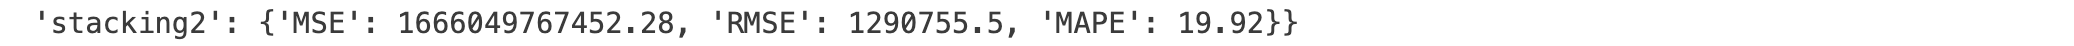

### Insights:
The stacking2 model has the lowest MAPE at 19.92%, indicating the best among the models. For an actual house price of $10,000,000, the RMSE of $1,290,755.50 suggests that the model's predictions are typically within approximately ±$1,290,755.50 of the true price. This implies that, on average, the model’s predictions are off by about ±19.92% of the actual price.

Tuning impact: Some models show improvement with tuning (e.g., Decision Tree, KNN, XGBoost), while others have worsened performance (e.g., AdaBoost, Gradient Boosting).

# Comparison
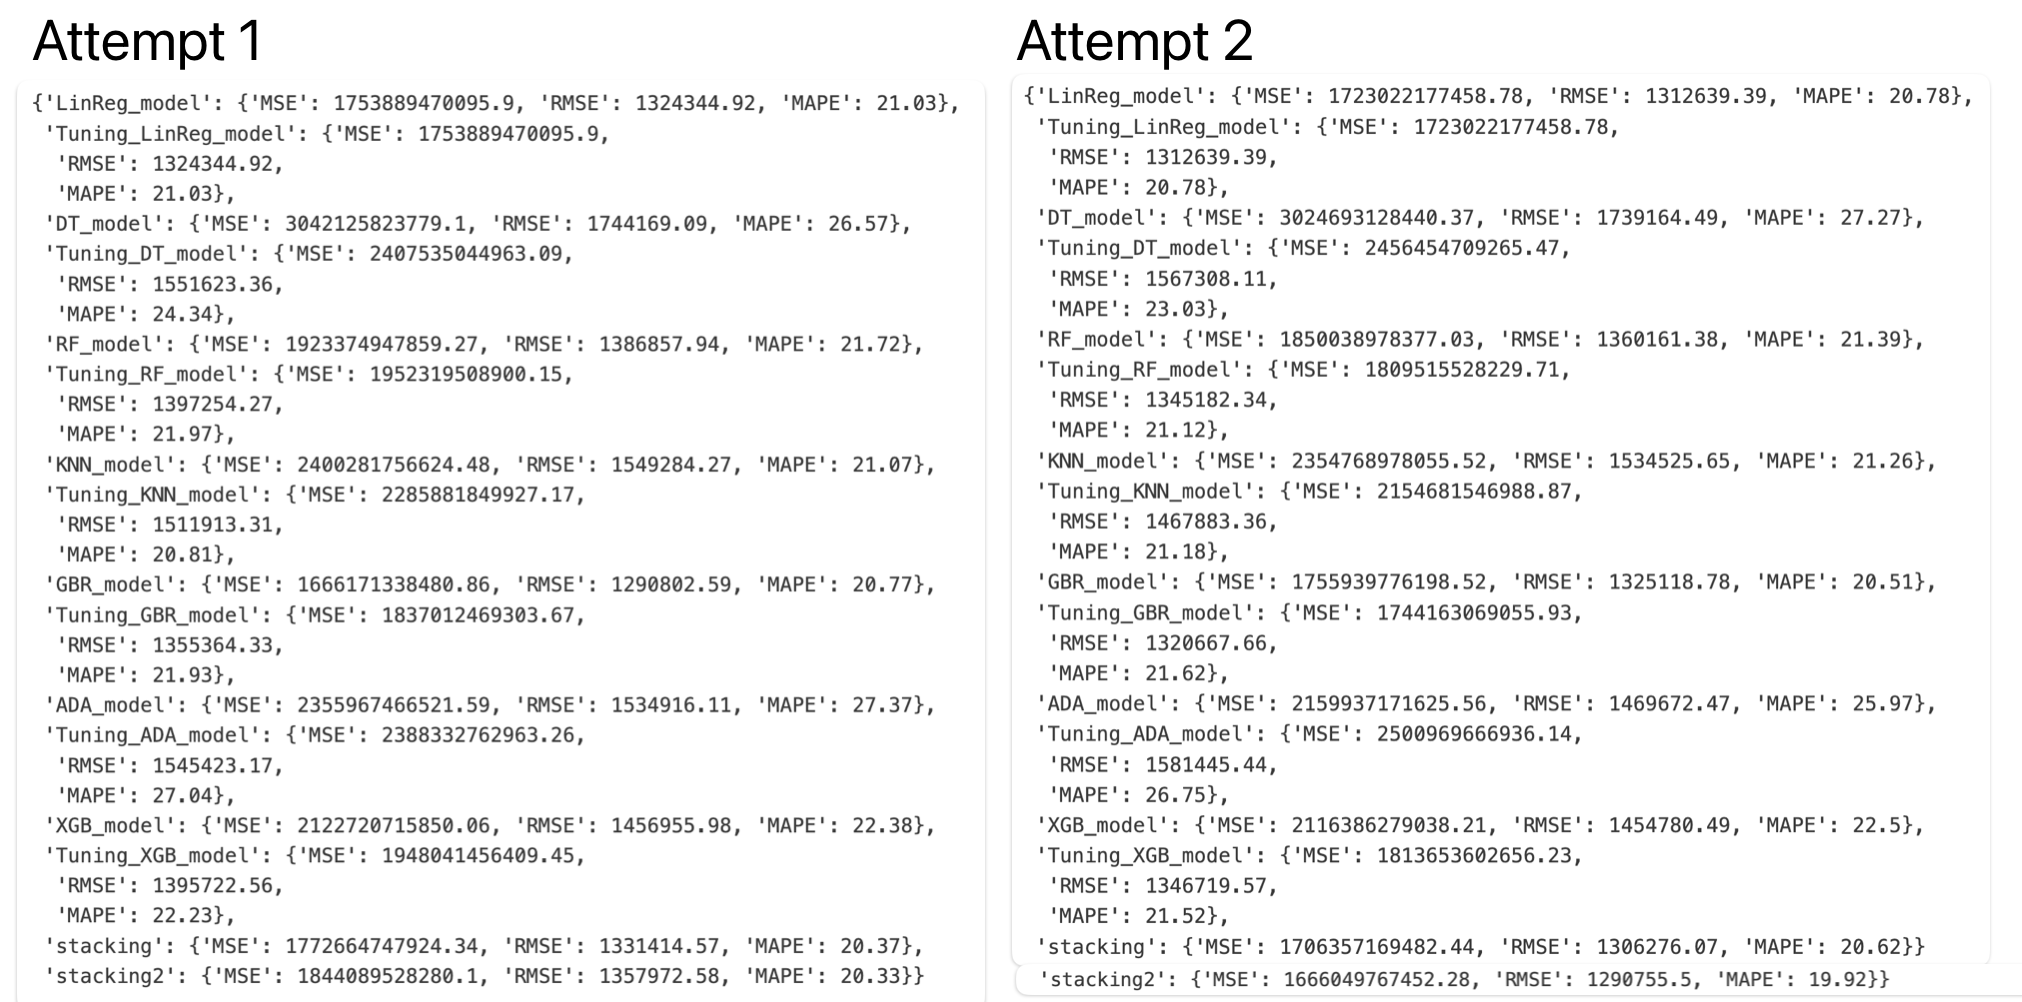

### Insights:
- Best model from attempt1: stacking2 (MAPE: 20.33)
- Best model from attempt2: stacking2 (MAPE: 19.22)
- With the second attempt, adding some features boosted the model performance, resulting in reduced errors, though not significantly. This is reflected in the lower MAPE for almost every algorithm except KNN. The best model with the lowest MAPE is stacking2 model from the second attempt as well